In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
from collections import defaultdict
from collections import Counter 
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

### Feature Engineering ---
* Each Categories having 5% values , we mark them as OTHERS . ( Make the Category of the Each Feature Others that have only 5 % of total observations )

In [2]:
def freq_dist(train):
    i=0
    data1 = pd.DataFrame(np.random.rand(0, 3) * 0, columns=['Feature_Name', 'Cat_Name', 'Cat_Count'])
    for feature in list(train.select_dtypes(include = ["object"]).columns):
        f = list(train.groupby(by=feature)[feature].count().index)
        c = list(train.groupby(by=feature)[feature].count())
        fc = zip(f, c)
        for idx, item in enumerate(fc):
            cat , co = item
            data1.loc[i, 'Feature_Name']     = feature
            data1.loc[i, 'Cat_Name']         = cat
            data1.loc[i, 'Cat_Count']        = co
            i+=1
    return data1

train = pd.read_csv("C:\\Users\\Sandip\\Desktop\\test_data\\Machine_Learning\\train_data.csv")
data = freq_dist(train)
data['Percent'] = data.Cat_Count/train.shape[0] * 100
data = data.set_index('Feature_Name')
data = data[data['Percent']<10]

for i in range(len(data)):
    col = data.iloc[i].name
    val = data.iloc[i].Cat_Name
    train[col] = train[col].replace(val,'Other', method='ffill')
    
train = pd.get_dummies(train, drop_first=True)
X = train.drop('SalePrice', axis=1).values
y = train['SalePrice'].values

### Supervised learning techniques

#### 1. LinearRegression

In [3]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8702091818911324
Root Mean Squared Error: 21490.970201248834


### 5-fold cross-validation scores using LinearRegression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.88804597 0.90488532 0.85896889 0.90676148 0.87883683]
Average 5-Fold CV Score: 0.8874996972954913


#### 2. Ridge

In [5]:
from sklearn.linear_model import Ridge


ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_score = ridge.score(X_test, y_test)
print(ridge_score)

0.8707703581824177


### Parameter tunning using cross_val_score + Ridge 

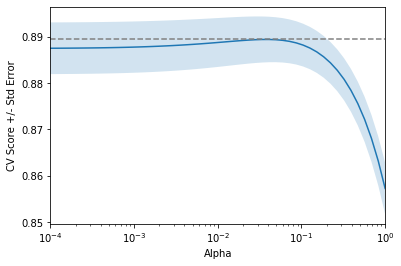

In [6]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
    
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=5)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### Parameter tunning using GridSearchCV + Ridge 

In [7]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = [0.1, 1, 10, 100, 1000]
param_grid = {'alpha': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = Ridge()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'alpha': 10}
Best score is 0.8898768818238177


#### 3. Lasso

In [8]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_score = lasso.score(X_test, y_test)
print(lasso_score)

0.8706977152312282


### Parameter tunning using GridSearchCV + Lasso 

In [9]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Lasso
import warnings
warnings.simplefilter("ignore")


# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('scaler', StandardScaler()),
         ('Lasso', Lasso())]
          
parameters = {'Lasso__alpha': [10, 20, 30, 50, 100, 1000]}

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
          
# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Accuracy: 0.8728961986167012
Tuned Model Parameters: {'Lasso__alpha': 100}
Best score is 0.8913861504416184


#### 4. GradientBoostingRegressor

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

#print("Tuned Model Parameters: {}".format(gbrt_best.best_params_))
print("Best score is {}".format(gbrt_best.score(X_test, y_test)))

Best score is 0.885167564687195


#### 5. RandomForestRegressor using GridSearchCV + tunning parameters

In [11]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor 
import warnings
warnings.simplefilter("ignore")


# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('scaler', StandardScaler()),
         ('RandomForestRegressor', RandomForestRegressor())]
          
parameters = {'RandomForestRegressor__n_estimators': [10, 100, 500]}

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
          
# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Accuracy: 0.8720222920053671
Tuned Model Parameters: {'RandomForestRegressor__n_estimators': 500}
Best score is 0.8897708228916034


#### 6 DecisionTreeRegressor using GridSearchCV + tunning parameters

In [12]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")



# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('scaler', StandardScaler()),
         ('DecisionTreeRegressor', DecisionTreeRegressor())]
          
parameters = {'DecisionTreeRegressor__min_samples_leaf': [10],
              'DecisionTreeRegressor__max_leaf_nodes'  : [500] }

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
          
# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Accuracy: 0.7459947192639055
Tuned Model Parameters: {'DecisionTreeRegressor__max_leaf_nodes': 500, 'DecisionTreeRegressor__min_samples_leaf': 10}
Best score is 0.7943635314520576


### 7.ElasticNet

In [13]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.9655172413793103}
Tuned ElasticNet R squared: 0.884506321529371
Tuned ElasticNet MSE: 407358122.86729205


### Feature Engineering ---
* PCA 

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=69)
projected = pca.fit_transform(X_std)


print(X_std.shape)
print(projected.shape)

(1175, 69)
(1175, 69)


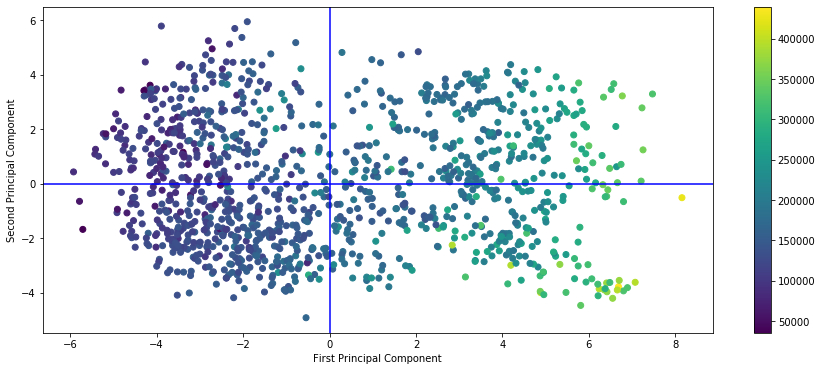

In [15]:
plt.figure(figsize = (15,6))
_ = plt.axvline(0, color='b')
_ = plt.axhline(0, color='b')
plt.scatter(projected[:, 0], projected[:, 1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar();

Looking at above plot I m taking 60 variables


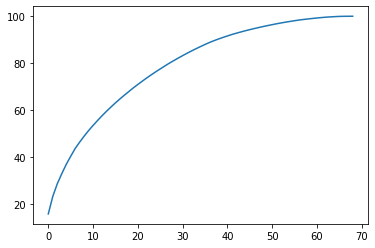

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

#Load data set
#data = pd.read_csv('Big_Mart_PCA.csv')

#convert it to numpy arrays
#X=data.values

#Scaling the values
X_scale = scale(X)

pca = PCA(n_components=69)

pca.fit(X_scale)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)

plt.plot(var1)
#plt.hist(var1)


print('Looking at above plot I m taking 60 variables')

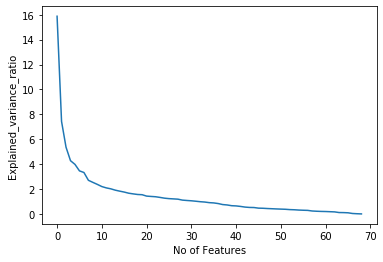

In [17]:
v = pd.DataFrame(pca.explained_variance_ratio_*100)
_= plt.plot(v)
_= plt.xlabel('No of Features')
_= plt.ylabel('Explained_variance_ratio')

### Q. Can you Please expain some unsupervised techniques for this project 